## Words Embeddings using GENSIM and word2vec

In [147]:
import re
import spacy
import gensim
import logging
import pandas as pd
import numpy as np
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [99]:
documents = pd.read_csv('./datos/simpsons_dataset.csv')
documents = documents.dropna()
documents = documents.reset_index(drop=True)
documents = documents.drop_duplicates()
print(documents.shape)
documents.head()

(126646, 2)


,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
def cleaning(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    if len(txt) > 2:
        return ' '.join(txt)
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in documents.spoken_words)
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(85955, 1)

In [111]:
from gensim.models.phrases import Phrases, Phraser
from collections import defaultdict
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

2022-07-10 16:33:41,140 : INFO : collecting all words and their counts
2022-07-10 16:33:41,140 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2022-07-10 16:33:41,255 : INFO : PROGRESS: at sentence #10000, processed 63557 words and 52687 word types
2022-07-10 16:33:41,385 : INFO : PROGRESS: at sentence #20000, processed 130936 words and 99557 word types
2022-07-10 16:33:41,513 : INFO : PROGRESS: at sentence #30000, processed 192963 words and 138094 word types
2022-07-10 16:33:41,647 : INFO : PROGRESS: at sentence #40000, processed 249832 words and 172088 word types
2022-07-10 16:33:41,787 : INFO : PROGRESS: at sentence #50000, processed 311270 words and 207883 word types
2022-07-10 16:33:41,903 : INFO : PROGRESS: at sentence #60000, processed 373576 words and 242881 word types
2022-07-10 16:33:42,031 : INFO : PROGRESS: at sentence #70000, processed 436425 words and 277780 word types
2022-07-10 16:33:42,171 : INFO : PROGRESS: at sentence #80000, processed 497889 wo

29643

In [117]:
w2v_model = gensim.models.Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)
w2v_model.build_vocab(sentences, progress_per=10000)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

2022-07-10 16:36:37,964 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.03>', 'datetime': '2022-07-10T16:36:37.964211', 'gensim': '4.2.0', 'python': '3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'created'}
2022-07-10 16:36:37,967 : INFO : collecting all words and their counts
2022-07-10 16:36:37,969 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-07-10 16:36:38,090 : INFO : PROGRESS: at sentence #10000, processed 61712 words, keeping 9500 word types
2022-07-10 16:36:38,205 : INFO : PROGRESS: at sentence #20000, processed 127347 words, keeping 14369 word types
2022-07-10 16:36:38,314 : INFO : PROGRESS: at sentence #30000, processed 187813 words, keeping 17427 word types
2022-07-10 16:36:38,412 : INFO : PROGRESS: at sentence #40000, processed 243323 words, keeping 20120 word types
2022-07-10 16:36:38,514 : INFO : PROGRESS: at sen

(5979088, 15709260)

In [144]:
w2v_model.wv.most_similar(positive=["homer_simpson"])
w2v_model.wv.most_similar(positive=["marge"])
w2v_model.wv.similarity("moe", 'tavern')
w2v_model.wv.similarity("homer_simpson", 'marge')
w2v_model.wv.similarity('maggie', 'baby')
w2v_model.wv.similarity('bart', 'nelson')
w2v_model.wv.doesnt_match(['jimbo', 'milhouse', 'nelson', 'bart', 'marge', 'homer'])
w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["marge"], topn=3)

[('admire', 0.5751004815101624),
 ('man', 0.5692721605300903),
 ('married', 0.5508677363395691)]

In [187]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def tsnescatterplot(model, word, list_names):
    """ 
    Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # Reduces the dimensionality from 300 to 15 dimensions with PCA
    reduc = PCA(n_components=15).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]], 'y': [y for y in Y[:, 1]], 'words': word_labels, 
                       'color': color_list})
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    # Basic plot
    p1 = sns.regplot(data=df, x = "x", y = "y", fit_reg = False, marker = "o", 
                     scatter_kws = {'s': 40, 'facecolors': df['color']})

    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
        xlabel = df["x"][line]
        ylabel = df['y'][line]
        title = df["words"][line].title()
        color = df['color'][line]
        p1.text(xlabel, ylabel, title, horizontalalignment='left', verticalalignment='bottom', 
                size='medium', color=color, weight='normal')

    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
    plt.title('t-SNE visualization for {}'.format(word.title()))

C:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


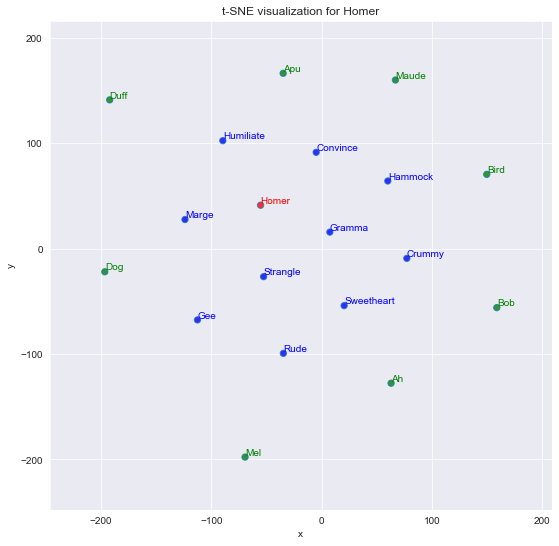

In [191]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

In [106]:
def preprocessing(document: str) -> dict:
    """
    iterate over all words in document identifing the word and frecuency
    remove all the problematic characters over the word
    and return a dictionary with the word as the key and the frecuency as the value
    """
    document = document.lower()
    document = re.sub('[^A-Za-z\']+', ' ', document)
    document = document.split()
    return document

In [94]:
documents['data'] = documents.spoken_words.apply(preprocessing)
documents.head()

,raw_character_text,spoken_words,data
0,Miss Hoover,"No, actually, it was a little of both. Sometim...","[no, actually, it, was, a, little, of, both, s..."
1,Lisa Simpson,Where's Mr. Bergstrom?,"[where's, mr, bergstrom]"
2,Miss Hoover,I don't know. Although I'd sure like to talk t...,"[i, don't, know, although, i'd, sure, like, to..."
3,Lisa Simpson,That life is worth living.,"[that, life, is, worth, living]"
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...,"[the, polls, will, be, open, from, now, until,..."


In [59]:
import multiprocessing
cores = multiprocessing.cpu_count()
cores

8

In [95]:
model = gensim.models.Word2Vec(list(documents.data), vector_size=250, window=10, min_count=2, workers=cores-1)
model.build_vocab(sentences, progress_per=10000)
model.train(documents.data, total_examples=len(documents.data),epochs=10)

2022-07-10 16:18:09,275 : INFO : collecting all words and their counts
2022-07-10 16:18:09,275 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-07-10 16:18:09,322 : INFO : PROGRESS: at sentence #10000, processed 97457 words, keeping 9630 word types
2022-07-10 16:18:09,356 : INFO : PROGRESS: at sentence #20000, processed 197197 words, keeping 14591 word types
2022-07-10 16:18:09,398 : INFO : PROGRESS: at sentence #30000, processed 306698 words, keeping 18969 word types
2022-07-10 16:18:09,432 : INFO : PROGRESS: at sentence #40000, processed 407596 words, keeping 21873 word types
2022-07-10 16:18:09,474 : INFO : PROGRESS: at sentence #50000, processed 500539 words, keeping 24589 word types
2022-07-10 16:18:09,506 : INFO : PROGRESS: at sentence #60000, processed 587268 words, keeping 26856 word types
2022-07-10 16:18:09,541 : INFO : PROGRESS: at sentence #70000, processed 684519 words, keeping 29160 word types
2022-07-10 16:18:09,565 : INFO : PROGRESS: at se

NameError: name 'sentences' is not defined

In [87]:
vector = model.wv['pineapple']
vector

array([ 1.26914820e-03, -1.05296209e-01,  2.39504293e-01, -7.01210871e-02,
       -2.79151887e-01,  1.17167205e-01, -3.73419710e-02,  2.72653252e-01,
       -6.52650818e-02,  1.05011351e-01, -6.84294403e-02, -6.25859797e-02,
       -1.35491580e-01,  2.83890665e-01,  2.50107199e-02,  2.23816670e-02,
       -8.46946463e-02, -4.16693538e-02, -1.92186952e-01,  3.42573337e-02,
       -2.43312046e-01, -9.67609957e-02,  1.17276393e-01, -6.12183213e-02,
       -6.11034073e-02, -4.67265882e-02,  2.00843319e-01, -7.52205774e-02,
       -4.44350332e-01,  2.26450622e-01,  3.92642803e-02, -1.97184812e-02,
       -1.98604256e-01, -6.33489713e-02,  1.84824139e-01, -9.69781168e-03,
        9.77793559e-02, -1.56488031e-01,  5.20672649e-02, -1.07623212e-01,
       -5.57471113e-03,  2.18029186e-01, -2.26331018e-02,  4.05998193e-02,
       -6.92730993e-02,  2.08391789e-02,  1.58661008e-01, -1.75039515e-01,
       -4.74462658e-02,  1.16804205e-02,  6.00495264e-02,  5.39638549e-02,
       -1.05940938e-01, -

In [88]:
model.wv.most_similar(positive=['babe'], topn=10)

[('isle', 0.5910033583641052),
 ('coney', 0.5768650770187378),
 ('raisin', 0.5644610524177551),
 ('slurry', 0.549674391746521),
 ('sow', 0.5444474816322327),
 ('tapas', 0.5443892478942871),
 ('melody', 0.5438315272331238),
 ('bourbon', 0.5405861735343933),
 ('yaaayyy', 0.538280189037323),
 ('mutt', 0.5372042059898376)]

In [92]:
pos = ["paris", "france"]
neg = ["spain", "to"]
model.wv.most_similar(positive=pos,negative=neg)

[('shade', 0.46659356355667114),
 ('bin', 0.45938462018966675),
 ('cities', 0.45396825671195984),
 ('america', 0.45155349373817444),
 ('female', 0.4411603808403015),
 ('december', 0.4405938982963562),
 ('tulsa', 0.43407726287841797),
 ('series', 0.425297349691391),
 ('oklahoma', 0.4232740104198456),
 ('wars', 0.422929048538208)]